# Modeling New Waves

This model is specifically designed to forecast the curve of the COVID-19 virus. It's important to recognize that viruses typically undergo phases of exponential growth and decline. To accurately reflect the dynamic nature of a virus in the model, it is crucial to limit the dataset. By constraining the scope of the data to a specific number of preceding days for model training, we enhance the model's capability to continuously adapt and accurately capture emerging new waves of the virus.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prepare import PrepareData
from functions import predict_all
plt.style.use('dashboard.mplstyle')

def general_logistic(x, L, x0, k, v):
    return L / ((1 + np.exp(-k * (x - x0))) ** (1 / v))

### Modifying Logistic Growth

Introducing the parameter `s` into the model enables a vertical data shift. This adjustment allows the model's range to extend from 0 to the value recorded on the final day, providing a more comprehensive and adaptable data representation.

$$f(x) = \frac{L - s}{(1 + e^{-k(x - x_0)})^{\frac{1}{v}}} + s$$


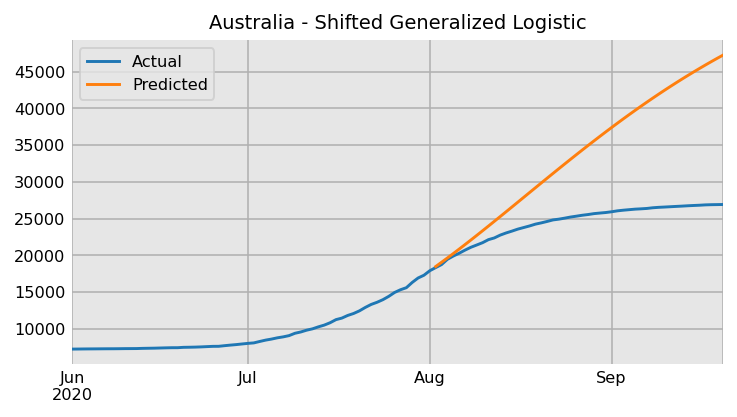

In [9]:
def general_logistic_shift(x, L, x0, k, v, s):
    return (L - s) / ((1 + np.exp(-k * (x - x0))) ** (1 / v)) + s

start_date = "2020-6-1"
last_date = "2020-08-01"
k_min, k_max = 0.01, 0.5
v_min, v_max = 0.01, 2
L_min, L_max = cases[last_date], 100_000

s_min, s_max = 0, cases[-1]
x0_min, x0_max = -50, 50
lower = L_min, x0_min, k_min, v_min, s_min
upper = L_max, x0_max, k_max, v_max, s_max
bounds = lower, upper
p0 = L_min * 5, 0, 0.1, 0.1, s_min
params, y_pred = predict_all(cases, start_date=start_date, last_date=last_date, n_smooth=15,
            n_pred=50, model=general_logistic_shift, p0=p0, bounds=bounds, 
            title="Australia - Shifted Generalized Logistic");

In [10]:
params

array([ 6.36418097e+04, -5.00000000e+01,  3.16212439e-02,  1.79212039e-02,
        6.84507526e+03])

While the model does not precisely predict the curve's trajectory, it successfully captures the overall shape of the curve, accurately reflecting its general pattern.

## Defining Functions to Create the Limits and Bounds

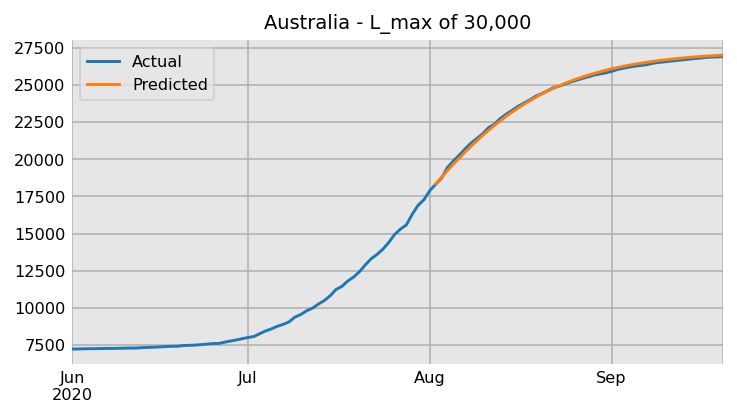

In [11]:
L_max = 30_000
lower = L_min, x0_min, k_min, v_min, s_min
upper = L_max, x0_max, k_max, v_max, s_max
bounds = lower, upper
p0 = L_max, 0, 0.1, 0.1, 0
predict_all(cases, start_date=start_date, last_date=last_date, n_smooth=15, 
            n_pred=50, model=general_logistic_shift, p0=p0, bounds=bounds, 
            title="Australia - L_max of 30,000");

In [13]:
from functions import smooth
s_smooth = smooth(cases[:last_date], n=15)
s_smooth_pct = s_smooth.pct_change()
s_smooth_pct.tail()

2020-07-28    0.033968
2020-07-29    0.034210
2020-07-30    0.034395
2020-07-31    0.034530
2020-08-01    0.034618
dtype: float64

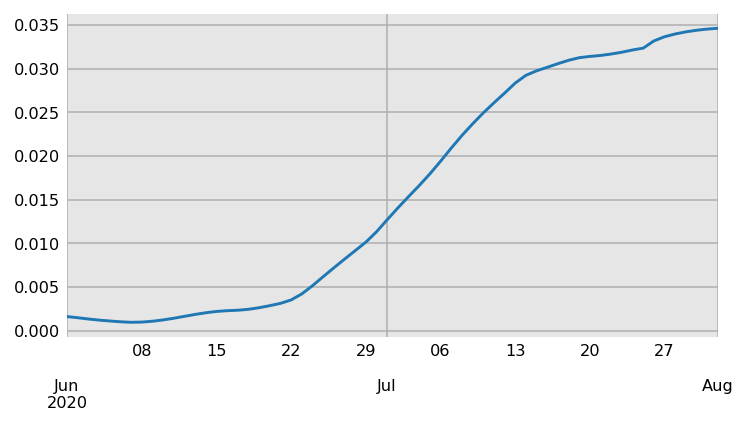

In [14]:
s_smooth_pct[start_date:].plot();

In [15]:
s_smooth[-1] * (1 + s_smooth_pct[-1]) ** 50

98115.4094208422

In [16]:
def get_L_limits(s, n1, n2):
    """
    Finds the min and max bounds for L and its initial guess

    Parameters
    ----------
    s : smoothed Series

    n1, n2 : min and max days of exponential growth

    Returns
    -------
    three-item tuple - min/max L bounds and initial
    """
    last_val = s[-1]
    last_pct = s.pct_change()[-1] + 1
    L_min = last_val * last_pct ** n1
    L_max = last_val * last_pct ** n2 + 1
    L0 = (L_max - L_min) / 2 + L_min
    if np.isnan(L_min):
        L_min, L_max, L0 = 0, 1, 0
    return L_min, L_max, L0

Use the function to get the bounds and initial guess.

In [17]:
get_L_limits(s_smooth, 5, 50)

(21214.473332194135, 98116.4094208422, 59665.44137651817)

This function is designed to return both the boundary values and the initial starting point.

In [18]:
def get_bounds_p0(s, n1=5, n2=50):
    """
    Finds the bounds and initial guesses for each
    parameter of the shifted logistic function

    Parameters
    ----------
    s : smoothed Series

    n1, n2 : min and max days of exponential growth

    Returns
    -------
    two-item tuple - bounds and p0
    """
    L_min, L_max, L0 = get_L_limits(s, n1, n2)
    x0_min, x0_max = -50, 50
    k_min, k_max = 0.01, 0.1
    v_min, v_max = 0.01, 2
    s_min, s_max = 0, s.iloc[-1] + 0.01
    s0 = s_max / 2
    lower = L_min, x0_min, k_min, v_min, s_min
    upper = L_max, x0_max, k_max, v_max, s_max
    bounds = lower, upper
    p0 = L0, 0, 0.1, 0.1, s0
    return bounds, p0

In [19]:
bounds, p0 = get_bounds_p0(s_smooth)
bounds

((21214.473332194135, -50, 0.01, 0.01, 0),
 (98116.4094208422, 50, 0.1, 2, 17895.01))

In [20]:
p0

(59665.44137651817, 0, 0.1, 0.1, 8947.505)

## Finding new waves

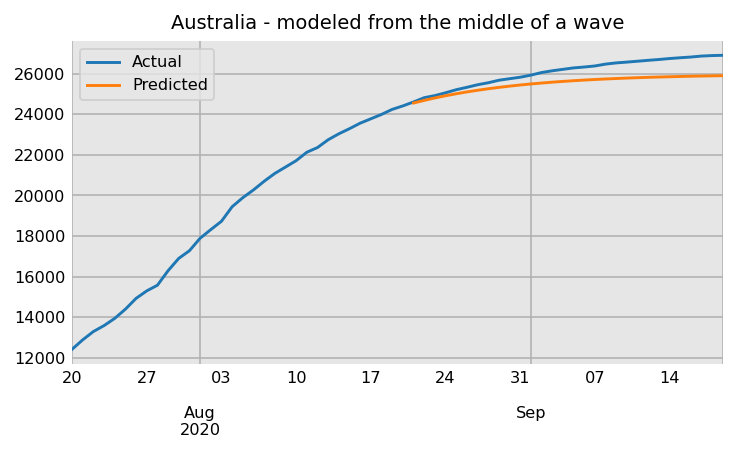

In [21]:
start_date = "2020-07-20"
last_date = "2020-08-20"
bounds, p0 = get_bounds_p0(cases[:last_date])
params = predict_all(cases, start_date=start_date, last_date=last_date, n_smooth=15, 
                     n_pred=30, model=general_logistic_shift, bounds=bounds, p0=p0,
                     title="Australia - modeled from the middle of a wave")



The model will undergo training using data from COVID-19 cases in Italy, recorded between March 20th and April 10th. This period will serve as the foundation for the training dataset. Utilizing this specific dataset, we aim to refine the model's ability to accurately forecast the pandemic's trajectory over the following 30 days. Notably, this model is proficient in adapting to data commencing from any phase within a pandemic wave, thereby enhancing its predictive accuracy.


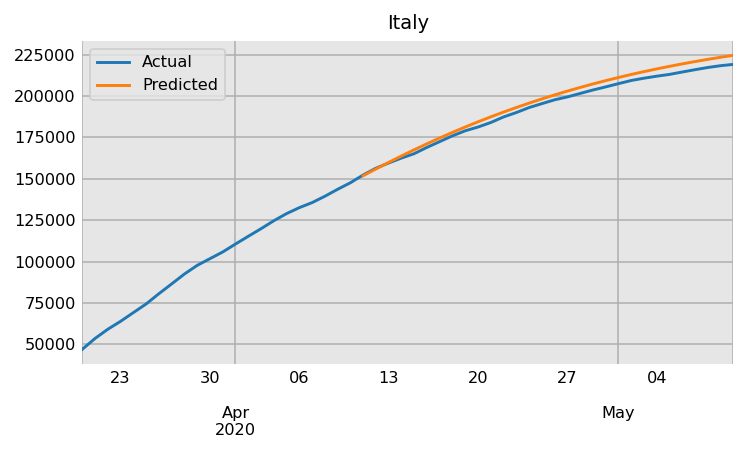

In [22]:
area = 'Italy'
start_date = '2020-03-20'
last_date='2020-04-10'
cases = data['world_cases'][area]
bounds, p0 = get_bounds_p0(cases[:last_date])
params = predict_all(cases, start_date=start_date, last_date=last_date, n_smooth=15,
                     n_pred=30, model=general_logistic_shift, p0=p0, bounds=bounds, 
                     title=area)

## Final Model

The predictive model for estimating COVID-19 case trends is based on a Generalized Logistic Function. This function is characterized by several key parameters: `L` represents the upper asymptote, `k` the growth rate, `x0` the horizontal shift, `v` controls asymmetry, and `s` denotes the vertical shift. To enhance the model's accuracy, the data undergoes preliminary smoothing using the Locally Weighted Scatterplot Smoothing (LOWESS) technique. The model's training predominantly focuses on recent data to effectively capture and predict emerging trends in new pandemic waves.

The functional form of the model is articulated as follows:

$$f(x) = \frac{L - s}{(1 + e^{-k(x - x_0)})^{\frac{1}{v}}} + s$$
